In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
import shap


In [2]:
file_path = 'cleaned_group_6_air_quality_data.csv'
data = pd.read_csv(file_path)
data.head()

Timestamp           City  AQI Dominant Pollutant  \
0  3/19/2025 15:00        Bangkok  116               pm25   
1  3/19/2025 14:50         Rayong   91               pm25   
2  3/19/2025 14:50           Yala   54               pm25   
3  3/19/2025 14:50  Nakhon Pathom  102               pm25   
4  3/19/2025 14:50   Nakhon Sawan   97               pm25   

   Particulate Matter (pm 2.5)  Particulate Matter (pm 10)  \
0                        116.0                        57.0   
1                         91.0                        38.0   
2                         54.0                         NaN   
3                        102.0                        25.0   
4                         97.0                        70.0   

   Carbon monoxide (co)  Ozone (o3)  Humidity (h)  Atmospheric Pressure (p)  \
0                   0.1        20.5           9.0                    1014.4   
1                   0.1        16.6           9.0                    1009.2   
2                   NaN         NaN          55.1                    1009.5   
3                   NaN         6.0           8.8                    1014.0   
4                   0.1        14.2           9.4                    1011.7   

   Rainfall or Precipitation (r)  Temperature (t)  Wind Speed (w)  
0                            1.1             32.8             2.0  
1                            6.6             31.2             2.0  
2                           99.9             32.8             6.1  
3                            NaN             31.2             1.0  
4                           99.1             31.7             1.5

In [3]:
# Data preprocessing

# Ensuring conversion to numerical columns
numeric_cols = ['AQI', 'Particulate Matter (pm 2.5)', 'Particulate Matter (pm 10)', 
                'Carbon monoxide (co)', 'Ozone (o3)', 'Humidity (h)', 
                'Atmospheric Pressure (p)', 'Rainfall or Precipitation (r)', 
                'Temperature (t)', 'Wind Speed (w)']

data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Filling in the mode for dominant pollution grouped by City
data['Dominant Pollutant'] = data.groupby('City')['Dominant Pollutant'].fillna(data['Dominant Pollutant'].mode()[0])
data['Dominant Pollutant'] = data['Dominant Pollutant'].astype("category")

# Filling in the median for missing AQI also grouped by the cities
data['AQI'] = data.groupby('City')['AQI'].transform(lambda x: x.fillna(x.median()))


columns_to_impute = ['Particulate Matter (pm 10)', 'Carbon monoxide (co)', 'Ozone (o3)', 'Rainfall or Precipitation (r)']

# Forward/Backward fill for null numerical columns
#data[columns_to_impute] = data.groupby('City')[columns_to_impute].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))

# Applying K-nearest Neighbors (KNN) imputation for the numerical null columns
knn_imputer = KNNImputer(n_neighbors=5)
data[columns_to_impute] = knn_imputer.fit_transform(data[columns_to_impute])

data.isna().sum()

C:\Users\Chan Nyein Kyaw\AppData\Local\Temp\ipykernel_9784\3411849582.py:12: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  data['Dominant Pollutant'] = data.groupby('City')['Dominant Pollutant'].fillna(data['Dominant Pollutant'].mode()[0])


Timestamp                        0
City                             0
AQI                              0
Dominant Pollutant               0
Particulate Matter (pm 2.5)      0
Particulate Matter (pm 10)       0
Carbon monoxide (co)             0
Ozone (o3)                       0
Humidity (h)                     0
Atmospheric Pressure (p)         0
Rainfall or Precipitation (r)    0
Temperature (t)                  0
Wind Speed (w)                   0
dtype: int64

In [4]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8400 entries, 0 to 8399
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Timestamp                      8400 non-null   object  
 1   City                           8400 non-null   object  
 2   AQI                            8400 non-null   float64 
 3   Dominant Pollutant             8400 non-null   category
 4   Particulate Matter (pm 2.5)    8400 non-null   float64 
 5   Particulate Matter (pm 10)     8400 non-null   float64 
 6   Carbon monoxide (co)           8400 non-null   float64 
 7   Ozone (o3)                     8400 non-null   float64 
 8   Humidity (h)                   8400 non-null   float64 
 9   Atmospheric Pressure (p)       8400 non-null   float64 
 10  Rainfall or Precipitation (r)  8400 non-null   float64 
 11  Temperature (t)                8400 non-null   float64 
 12  Wind Speed (w)                 840

In [5]:
#Applying IsolationForest for outliers detection
from sklearn.ensemble import IsolationForest


numerical_columns = ['Particulate Matter (pm 2.5)', 'Particulate Matter (pm 10)', 'Carbon monoxide (co)', 
                     'Ozone (o3)', 'Humidity (h)', 'Atmospheric Pressure (p)', 'Rainfall or Precipitation (r)', 
                     'Temperature (t)', 'Wind Speed (w)']


iso_forest = IsolationForest(contamination=0.05, n_estimators=20, warm_start=True, random_state=42) 

outlier_pred = iso_forest.fit_predict(data[numerical_columns])

outliers = outlier_pred == -1
outlier_rows = data[outliers]
outlier_rows

Timestamp        City   AQI Dominant Pollutant  \
2     3/19/2025 14:50        Yala  54.0               pm25   
5     3/19/2025 14:50  Chiang Rai  38.0               pm25   
13    3/19/2025 14:47        Yala  54.0               pm25   
15    3/19/2025 14:47  Chiang Rai  38.0               pm25   
32    3/19/2025 15:00  Chiang Rai  38.0               pm25   
...               ...         ...   ...                ...   
8105  4/16/2025 17:00  Udon Thani  15.0               pm25   
8190   4/17/2025 0:00   Khon Kaen  84.0               pm25   
8202   4/17/2025 1:00   Khon Kaen  70.0               pm25   
8214   4/17/2025 2:00   Khon Kaen  82.0               pm25   
8226   4/17/2025 3:00   Khon Kaen  78.0               pm25   

      Particulate Matter (pm 2.5)  Particulate Matter (pm 10)  \
2                            54.0                    33.00000   
5                            38.0                    20.00000   
13                           54.0                    33.00000   
15                           38.0                    20.00000   
32                           38.0                    20.00000   
...                           ...                         ...   
8105                         15.0                     9.00000   
8190                         84.0                    49.38118   
8202                         70.0                    49.38118   
8214                         82.0                    49.38118   
8226                         78.0                    49.38118   

      Carbon monoxide (co)  Ozone (o3)  Humidity (h)  \
2                 0.100000   14.200000          55.1   
5                 0.100000   12.700000          84.3   
13                0.100000   14.200000          55.1   
15                0.100000   12.700000          84.3   
32                0.100000   12.700000          84.3   
...                    ...         ...           ...   
8105              0.100000   13.480000          50.5   
8190              0.100024   11.104821          88.0   
8202              0.100024   11.104821          83.0   
8214              0.100024   11.104821          88.0   
8226              0.100024   11.104821          88.0   

      Atmospheric Pressure (p)  Rainfall or Precipitation (r)  \
2                       1009.5                      99.900000   
5                        985.8                      20.560000   
13                      1009.5                      99.900000   
15                       985.8                      20.560000   
32                       985.8                      20.560000   
...                        ...                            ...   
8105                     984.9                       0.100000   
8190                    1012.0                      35.069194   
8202                    1011.0                      35.069194   
8214                    1010.0                      35.069194   
8226                    1010.0                      35.069194   

      Temperature (t)  Wind Speed (w)  
2                32.8             6.1  
5                17.7             3.0  
13               32.8             6.1  
15               17.7             3.0  
32               17.7             3.0  
...               ...             ...  
8105             34.8             3.6  
8190             26.0             4.6  
8202             26.0             5.1  
8214             25.0             4.6  
8226             25.0             4.6  

[420 rows x 13 columns]

Most outliers will be left undropped for the purpose of anomaly detection.

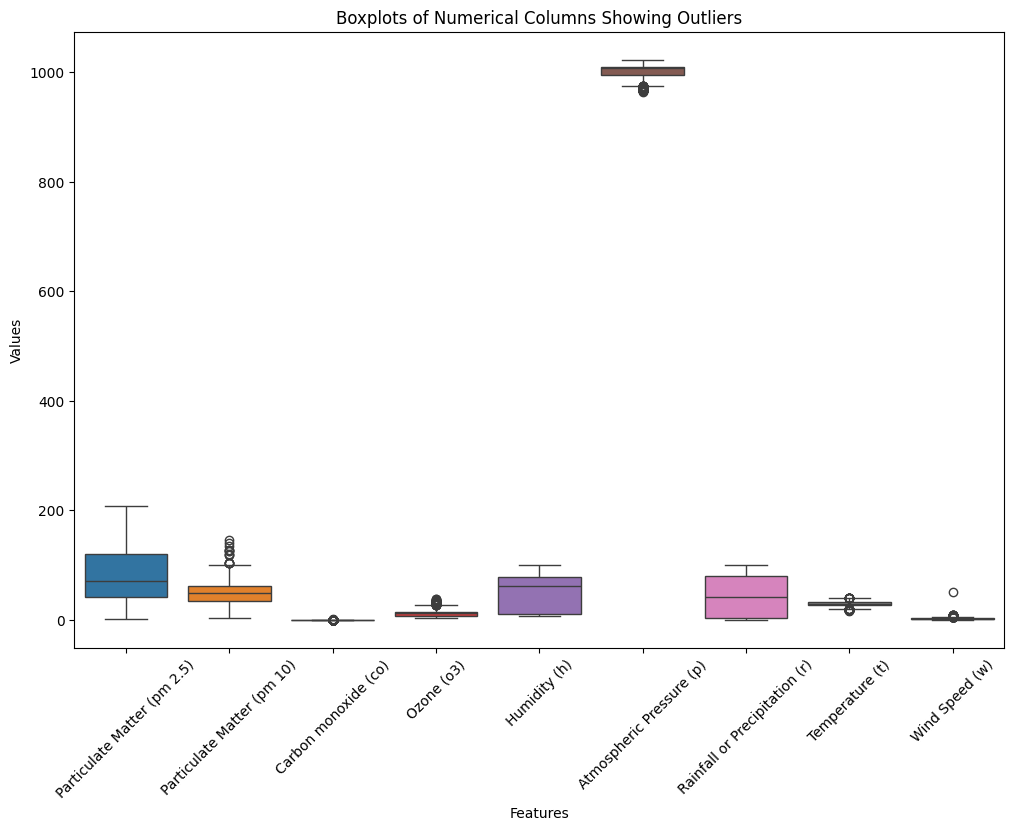

In [6]:
# Outliers box plot
plt.figure(figsize=(12, 8))

sns.boxplot(data=data[numerical_columns])

plt.title("Boxplots of Numerical Columns Showing Outliers")
plt.xlabel("Features")
plt.ylabel("Values")

plt.xticks(rotation=45)
plt.show()

In [7]:
#Detected one single huge anomaly in wind speed
data.sort_values(by='Wind Speed (w)', ascending=False).head(5)

Timestamp        City   AQI Dominant Pollutant  \
4528    4/4/2025 6:00  Chiang Mai  86.0               pm25   
5820   4/8/2025 18:00     Bangkok  98.0               pm25   
1153  3/23/2025 13:00       Satun  69.0               pm25   
613   3/21/2025 16:00       Satun  60.0               pm25   
1189  3/23/2025 16:00       Satun  67.0               pm25   

      Particulate Matter (pm 2.5)  Particulate Matter (pm 10)  \
4528                         86.0                        82.0   
5820                         98.0                        59.0   
1153                         69.0                        21.0   
613                          60.0                        21.0   
1189                         67.0                        21.0   

      Carbon monoxide (co)  Ozone (o3)  Humidity (h)  \
4528                   0.1        14.6          70.7   
5820                   0.1        21.7          70.0   
1153                   0.1         6.4          58.0   
613                    0.1         6.4          58.0   
1189                   0.1         6.4          58.0   

      Atmospheric Pressure (p)  Rainfall or Precipitation (r)  \
4528                     974.9                          79.28   
5820                    1010.0                           3.80   
1153                    1013.0                          99.42   
613                     1011.0                          99.42   
1189                    1010.0                          99.42   

      Temperature (t)  Wind Speed (w)  
4528             27.4            50.9  
5820             39.0             9.2  
1153             31.0             8.2  
613              31.0             7.7  
1189             31.0             7.7

In [8]:
#cleaning the wind speed outlier
data = data.drop(index=4528)


In [9]:
data['Wind Speed (w)'].describe()

count    8399.000000
mean        1.838350
std         1.092762
min         0.100000
25%         1.000000
50%         1.500000
75%         2.500000
max         9.200000
Name: Wind Speed (w), dtype: float64

# Hypothesis 1

H(0): PM2.5 levels in higher elevation and coastal cities are equal to or higher than those in other cities.

H(1): PM2.5 levels in higher elevation and coastal cities are lower than those in other cities due to better dispersion of pollutants.

In [10]:
#Feature Engineering

#clean city names by removing whitespaces)
data['City'] = data['City'].str.strip() 

# Creating Elevation Column (High vs Low Elevation)
elevation_map = {
    'Chiang Mai': 'High',
    'Chiang Rai': 'High',
    'Yala': 'Low',
    'Udon Thani': 'Low',
    'Khon Kaen': 'Low',
    'Nakhon Sawan': 'Low',
    'Krabi': 'Low',  
    'Bangkok': 'Low',
    'Nakhon Pathom': 'Low',
    'Surat Thani': 'Low',
    'Rayong': 'Low',
    'Satun': 'Low'
}

data['Elevation'] = data['City'].map(elevation_map)

# Creating Coastal Column (Coastal vs Inland)
coastal_map = {
    'Chiang Mai': 'Inland',
    'Chiang Rai': 'Inland',
    'Yala': 'Inland',
    'Udon Thani': 'Inland',
    'Khon Kaen': 'Inland',
    'Nakhon Sawan': 'Inland',
    'Krabi': 'Coastal',
    'Bangkok': 'Inland',
    'Nakhon Pathom': 'Inland',
    'Surat Thani': 'Coastal',  
    'Rayong': 'Coastal', 
    'Satun': 'Coastal' 
}


#map again as numerical values 1 or 0
data['Coastal'] = data['City'].map(coastal_map)

data['Elevation'] = data['Elevation'].map({'High': 1, 'Low': 0}) 
data['Coastal'] = data['Coastal'].map({'Coastal': 1, 'Inland': 0}) 

# converting timestamp to datetime for extracting more time data features
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%m/%d/%Y %H:%M')
data['Hour'] = data['Timestamp'].dt.hour
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek

# create timeofday categories
data['TimeOfDay'] = pd.cut(data['Hour'], 
                         bins=[0, 6, 12, 18, 24],
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                         include_lowest=True)

# Create AQI categories based on US EPA standards
bins = [0, 50, 100, 150, 200, 300, float('inf')]
labels = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
data['AQI_Category'] = pd.cut(data['AQI'], bins=bins, labels=labels)

data.dtypes

Timestamp                        datetime64[ns]
City                                     object
AQI                                     float64
Dominant Pollutant                     category
Particulate Matter (pm 2.5)             float64
Particulate Matter (pm 10)              float64
Carbon monoxide (co)                    float64
Ozone (o3)                              float64
Humidity (h)                            float64
Atmospheric Pressure (p)                float64
Rainfall or Precipitation (r)           float64
Temperature (t)                         float64
Wind Speed (w)                          float64
Elevation                                 int64
Coastal                                   int64
Hour                                      int32
Day                                       int32
Month                                     int32
DayOfWeek                                 int32
TimeOfDay                              category
AQI_Category                           c

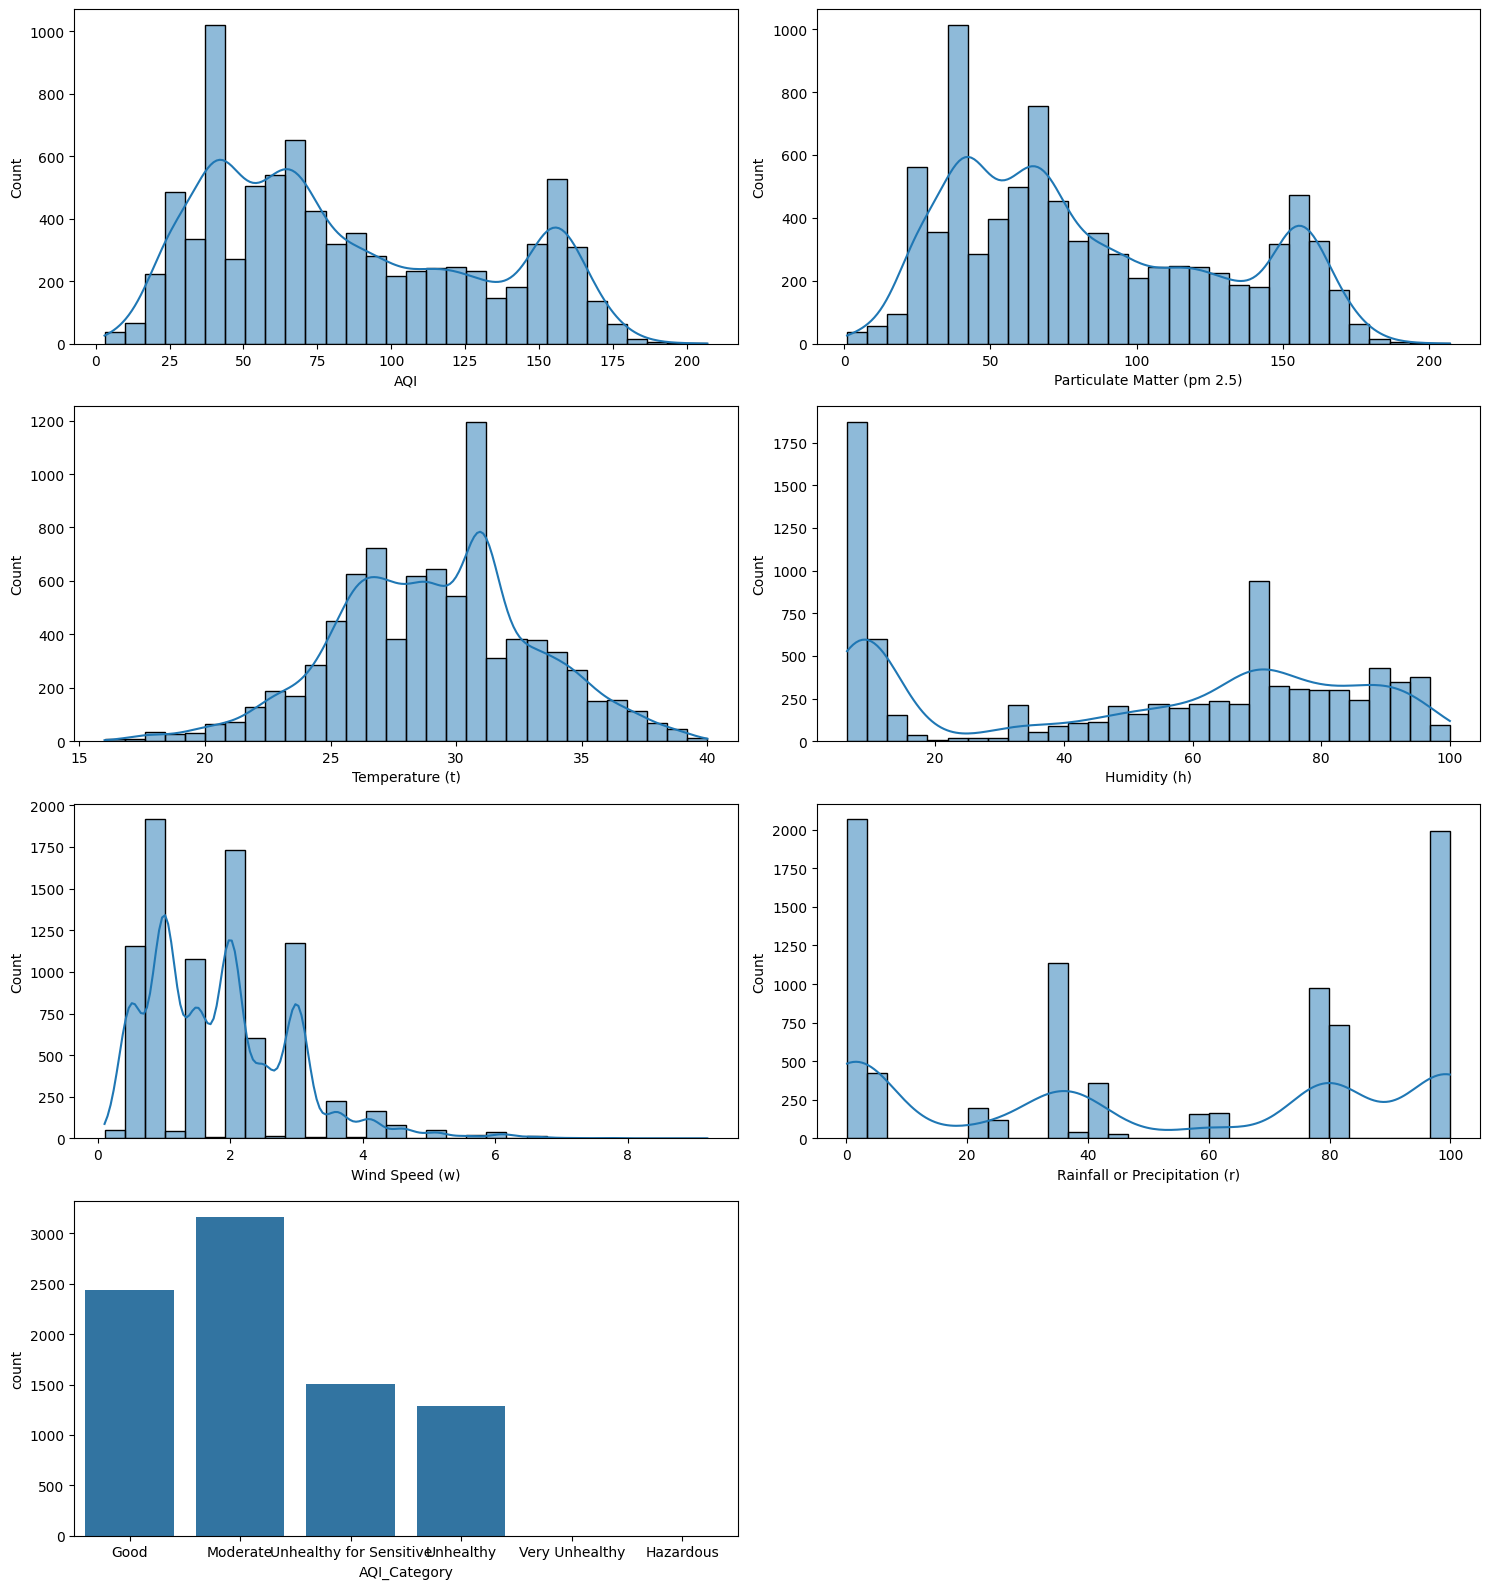

In [11]:
# Exploratory Data Analysis

# Checking Distribution of key variables
fig, axes = plt.subplots(4, 2, figsize=(15, 16))

sns.histplot(data['AQI'], bins=30, kde=True, ax=axes[0, 0])
sns.histplot(data['Particulate Matter (pm 2.5)'], bins=30, kde=True, ax=axes[0, 1])
sns.histplot(data['Temperature (t)'], bins=30, kde=True, ax=axes[1, 0])
sns.histplot(data['Humidity (h)'], bins=30, kde=True, ax=axes[1, 1])
sns.histplot(data['Wind Speed (w)'], bins=30, kde=True, ax=axes[2, 0])
sns.histplot(data['Rainfall or Precipitation (r)'], bins=30, kde=True, ax=axes[2, 1])
sns.countplot(x='AQI_Category', data=data, ax=axes[3, 0])
fig.delaxes(axes[3, 1])
plt.tight_layout()
plt.show()


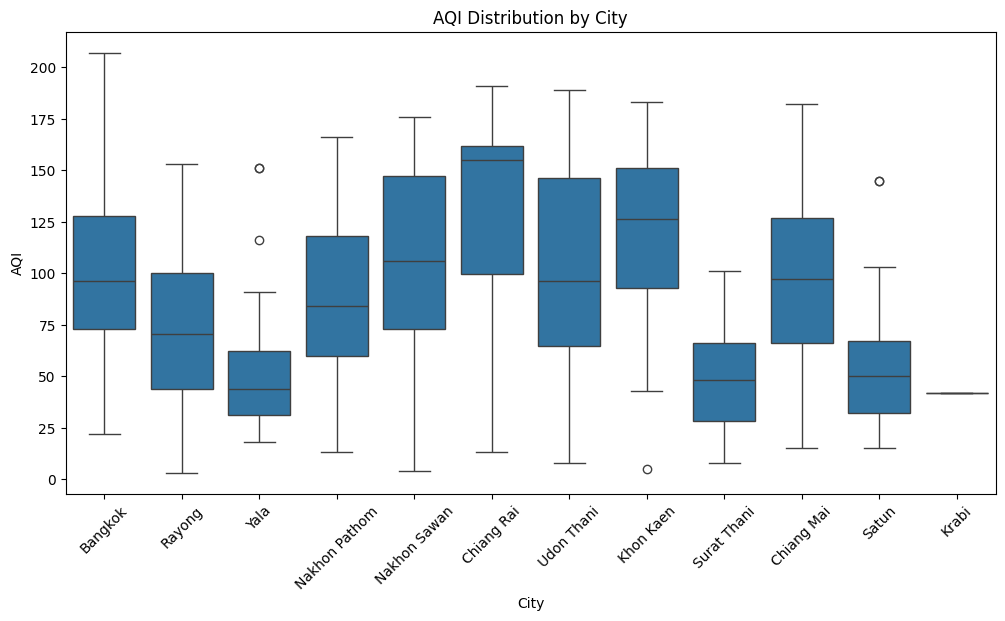

Average AQI by City:
 City
Chiang Rai       128.355714
Khon Kaen        122.080000
Nakhon Sawan     107.024286
Bangkok          102.842857
Udon Thani        99.810000
Chiang Mai        96.446352
Nakhon Pathom     90.172857
Rayong            73.570000
Satun             49.631429
Surat Thani       47.515714
Yala              46.555714
Krabi             42.000000
Name: AQI, dtype: float64


In [12]:
# AQI distribution by city
plt.figure(figsize=(12, 6))
sns.boxplot(x='City', y='AQI', data=data)
plt.xticks(rotation=45)
plt.title('AQI Distribution by City')
plt.show()

# Top polluted cities
city_avg = data.groupby('City')['AQI'].mean().sort_values(ascending=False)
print("Average AQI by City:\n", city_avg)

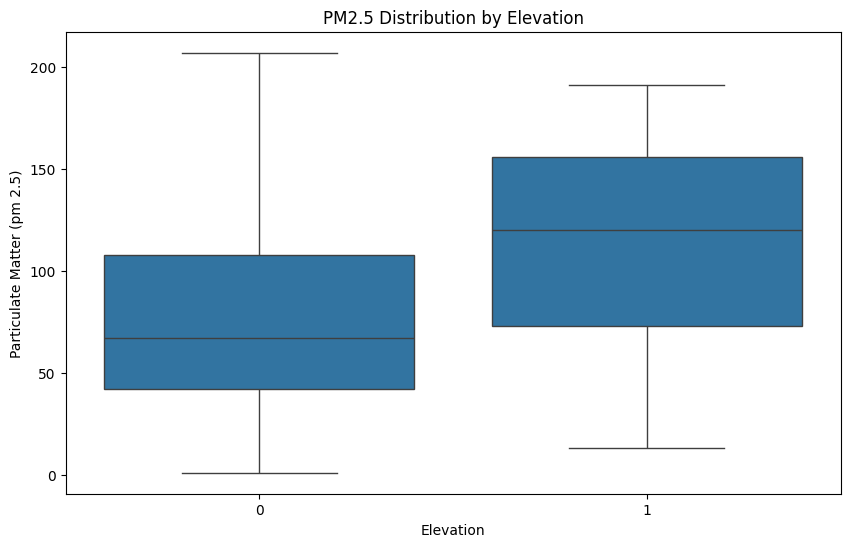

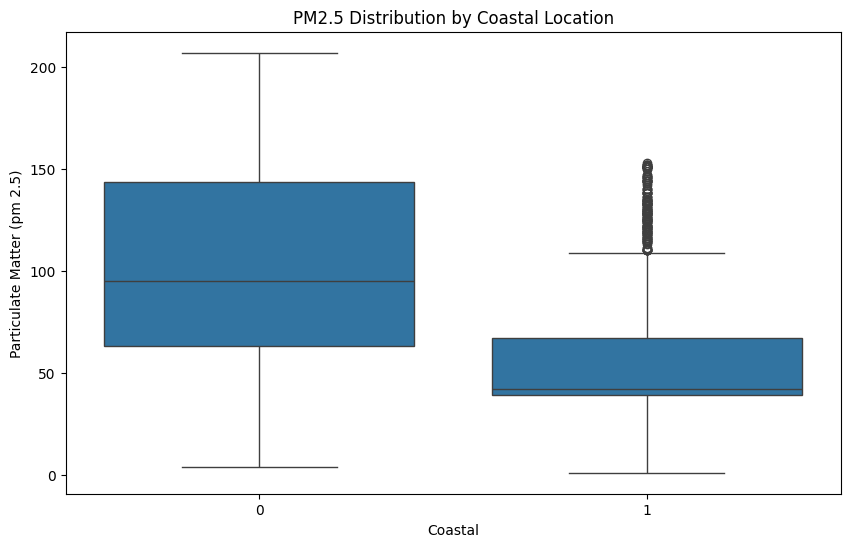

In [13]:
# Distribution of PM2.5 across elevation and coastal status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Elevation', y='Particulate Matter (pm 2.5)', data=data)
plt.title('PM2.5 Distribution by Elevation')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Coastal', y='Particulate Matter (pm 2.5)', data=data)
plt.title('PM2.5 Distribution by Coastal Location')
plt.show()


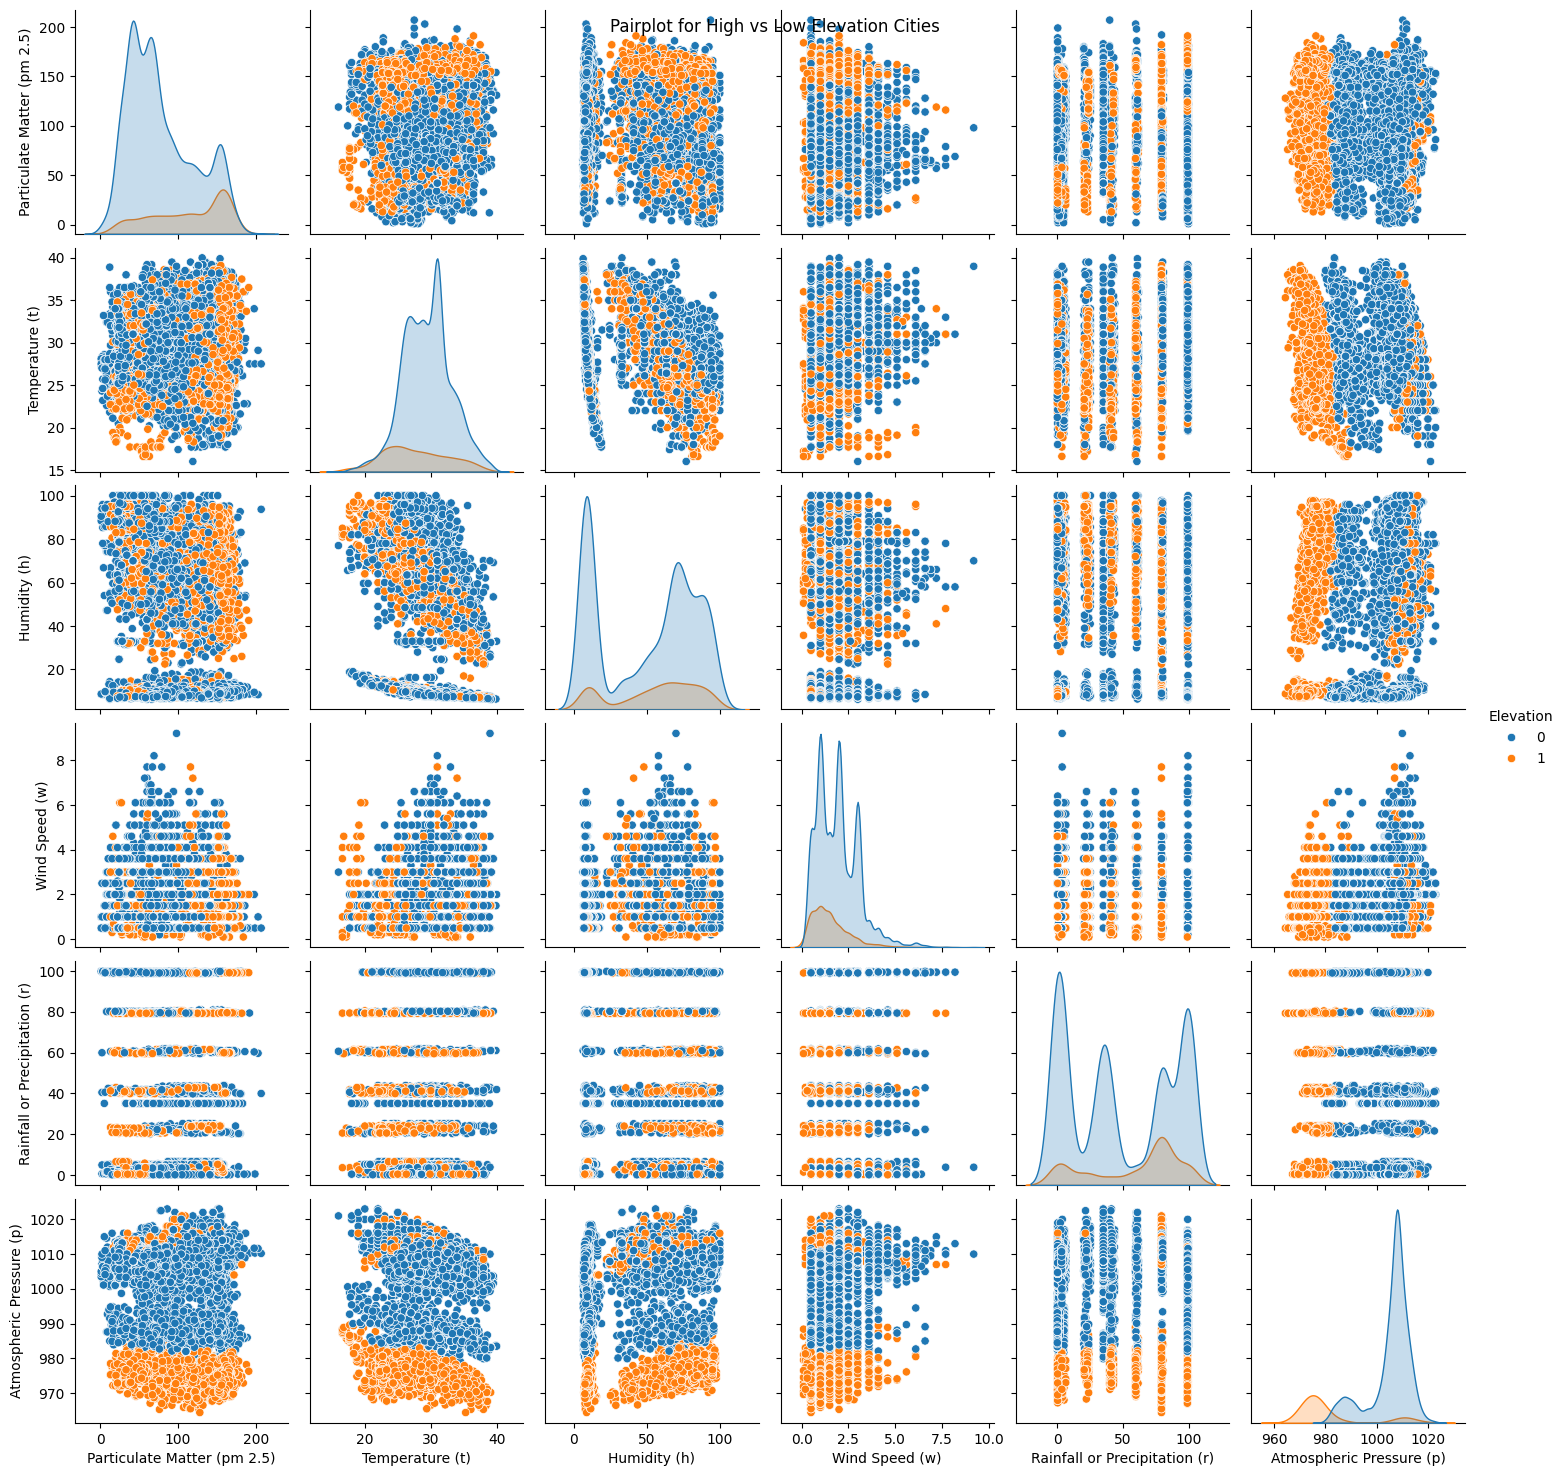

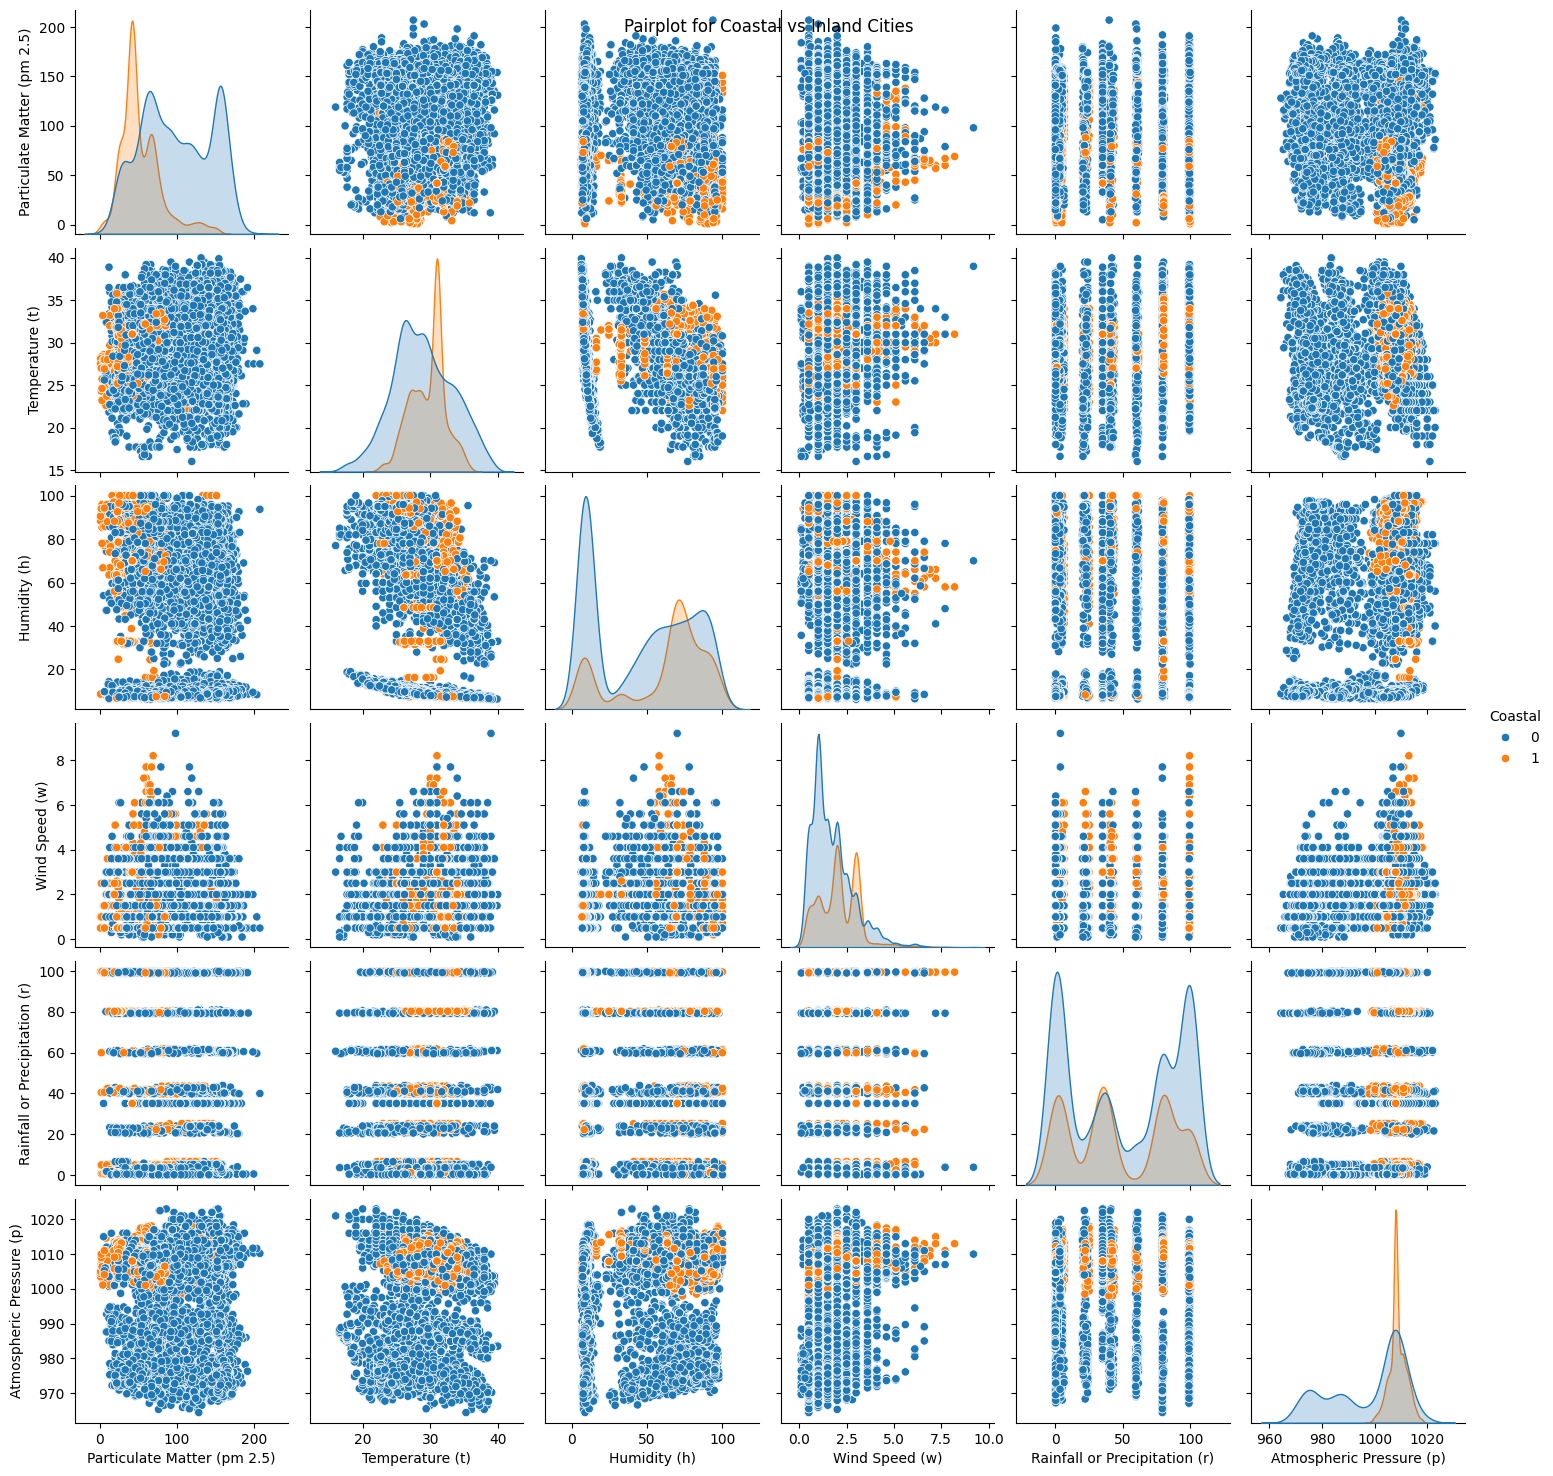

In [14]:
# Pairplot of Elevation and Coastal Cities
sns.pairplot(data, hue='Elevation', vars=['Particulate Matter (pm 2.5)', 'Temperature (t)', 'Humidity (h)', 
                                          'Wind Speed (w)', 'Rainfall or Precipitation (r)', 'Atmospheric Pressure (p)'])
plt.suptitle("Pairplot for High vs Low Elevation Cities")
plt.show()

sns.pairplot(data, hue='Coastal', vars=['Particulate Matter (pm 2.5)', 'Temperature (t)', 'Humidity (h)', 
                                        'Wind Speed (w)', 'Rainfall or Precipitation (r)', 'Atmospheric Pressure (p)'])
plt.suptitle("Pairplot for Coastal vs Inland Cities")
plt.show()

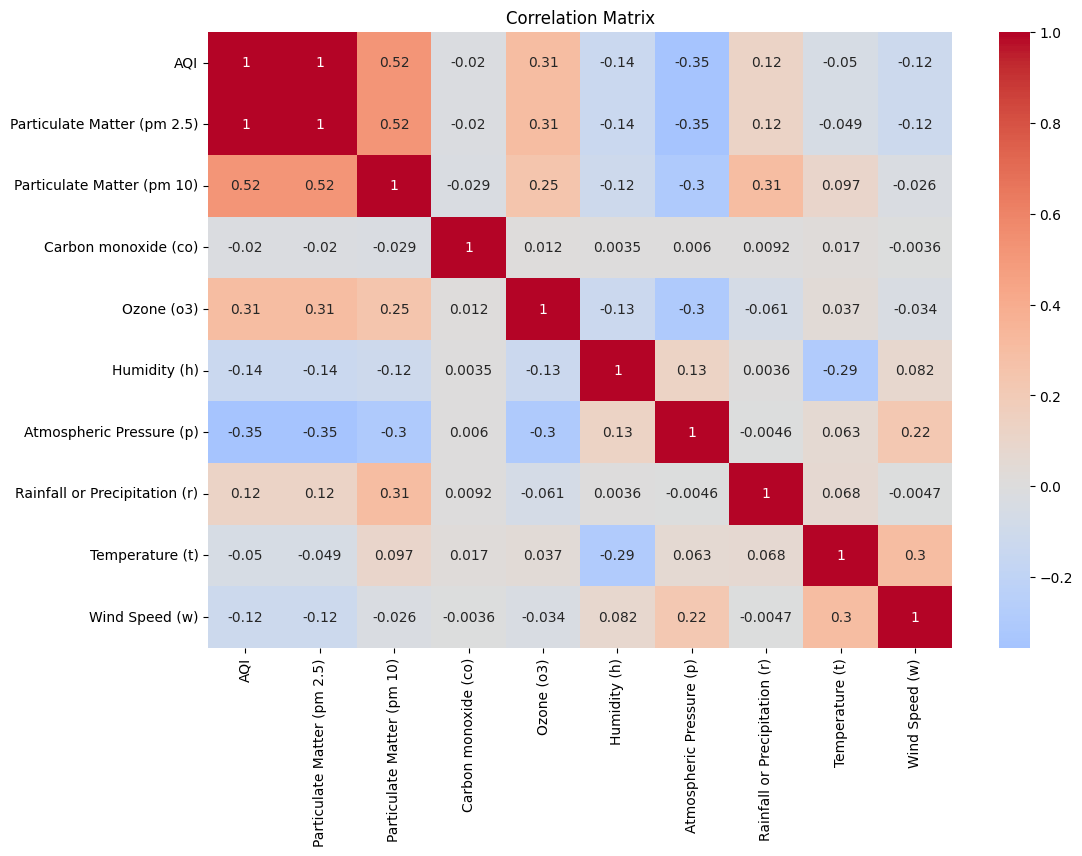

In [15]:
# Correlation matrix
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [16]:
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

# Test Hypothesis: High Elevation vs Low Elevation PM2.5 levels
high_elevation = data[data['Elevation'] == 1]['Particulate Matter (pm 2.5)']
low_elevation = data[data['Elevation'] == 0]['Particulate Matter (pm 2.5)']
# Test Hypothesis: Coastal vs Inland PM2.5 levels
coastal = data[data['Coastal'] == 1]['Particulate Matter (pm 2.5)']
inland = data[data['Coastal'] == 0]['Particulate Matter (pm 2.5)']

# Performing T-test
t_stat, p_value_elevation = ttest_ind(high_elevation, low_elevation)
print(f"T-statistic for High vs Low Elevation: {t_stat}, p-value: {p_value_elevation}")
t_stat_coastal, p_value_coastal = ttest_ind(coastal, inland)
print(f"T-statistic for Coastal vs Inland: {t_stat_coastal}, p-value: {p_value_coastal}")

# Performing ANOVA for PM2.5 based on Elevation and Coastal status
f_stat_elevation, p_value_elevation = f_oneway(high_elevation, low_elevation)
f_stat_coastal, p_value_coastal = f_oneway(coastal, inland)

print(f"ANOVA for Elevation: F-statistic = {f_stat_elevation}, p-value = {p_value_elevation}")
print(f"ANOVA for Coastal: F-statistic = {f_stat_coastal}, p-value = {p_value_coastal}")


T-statistic for High vs Low Elevation: 26.942584591258782, p-value: 2.0208763684063884e-153
T-statistic for Coastal vs Inland: -49.97733397565279, p-value: 0.0
ANOVA for Elevation: F-statistic = 725.9028644571353, p-value = 2.0208763684085037e-153
ANOVA for Coastal: F-statistic = 2497.7339113139383, p-value = 0.0


In [17]:
# Machine learning model training 

X = data[['Elevation', 'Coastal', 'Temperature (t)', 'Humidity (h)', 'Wind Speed (w)', 'Rainfall or Precipitation (r)', 'Atmospheric Pressure (p)']]
y = data['Particulate Matter (pm 2.5)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest Regressor Model

#rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#rf_model.fit(X_train, y_train)
#y_pred_rf = rf_model.predict(X_test)

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=params, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Linear Regression:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr)}")
print(f"R2: {r2_score(y_test, y_pred_lr)}")

print("\nRandom Forest Regressor:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"R2: {r2_score(y_test, y_pred_rf)}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': None, 'bootstrap': False}
Linear Regression:
MAE: 31.744468479368255
RMSE: 38.944171621797636
MSE: 1516.6485033080285
R2: 0.22977395260674427

Random Forest Regressor:
MAE: 11.446997045068027
RMSE: 19.820135474691558
MSE: 392.83777023512675
R2: 0.800498347260407


In [18]:
# Perform K-Fold Cross-Validation (5-fold)
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='neg_mean_squared_error')

# Output the cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score (MSE): {-cv_scores.mean()}")

Cross-validation scores: [-1756.53782684 -1247.87286436 -1069.61745925  -729.47948421
 -2420.16291553]
Mean CV score (MSE): 1444.7341100380522


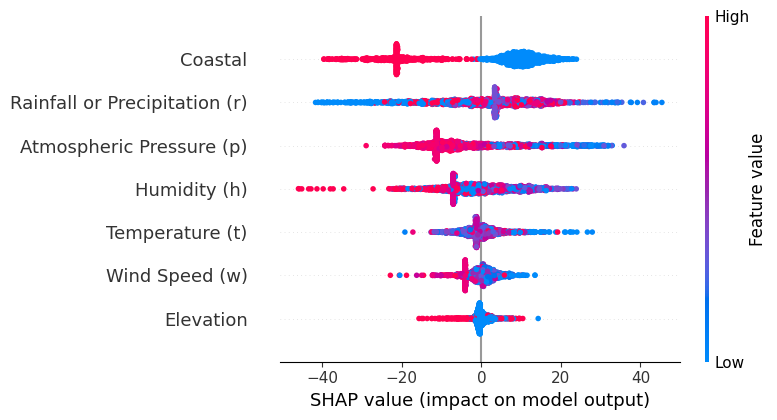

In [19]:
# SHAP Analaysis
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

#SHAP Plot
shap.summary_plot(shap_values, X_test)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# Hypothesis 2

H(0): Wind speed and rainfall levels do not reduce PM2.5 concentrations.

H(1): Higher wind speed or higher rainfall levels lead to lower PM2.5 concentrations due to increased dispersion and settling of particles.

In [20]:
#Feature Engineering
data['Wind Speed Category'] = np.where(data['Wind Speed (w)'] > data['Wind Speed (w)'].median(), 'High', 'Low')

data['Rainfall Category'] = np.where(data['Rainfall or Precipitation (r)'] > data['Rainfall or Precipitation (r)'].median(), 'High', 'Low')

data.head()

Timestamp           City    AQI Dominant Pollutant  \
0 2025-03-19 15:00:00        Bangkok  116.0               pm25   
1 2025-03-19 14:50:00         Rayong   91.0               pm25   
2 2025-03-19 14:50:00           Yala   54.0               pm25   
3 2025-03-19 14:50:00  Nakhon Pathom  102.0               pm25   
4 2025-03-19 14:50:00   Nakhon Sawan   97.0               pm25   

   Particulate Matter (pm 2.5)  Particulate Matter (pm 10)  \
0                        116.0                        57.0   
1                         91.0                        38.0   
2                         54.0                        33.0   
3                        102.0                        25.0   
4                         97.0                        70.0   

   Carbon monoxide (co)  Ozone (o3)  Humidity (h)  Atmospheric Pressure (p)  \
0                   0.1        20.5           9.0                    1014.4   
1                   0.1        16.6           9.0                    1009.2   
2                   0.1        14.2          55.1                    1009.5   
3                   0.1         6.0           8.8                    1014.0   
4                   0.1        14.2           9.4                    1011.7   

   ...  Elevation  Coastal  Hour  Day  Month  DayOfWeek  TimeOfDay  \
0  ...          0        0    15   19      3          2  Afternoon   
1  ...          0        1    14   19      3          2  Afternoon   
2  ...          0        0    14   19      3          2  Afternoon   
3  ...          0        0    14   19      3          2  Afternoon   
4  ...          0        0    14   19      3          2  Afternoon   

              AQI_Category  Wind Speed Category Rainfall Category  
0  Unhealthy for Sensitive                 High               Low  
1                 Moderate                 High               Low  
2                 Moderate                 High              High  
3  Unhealthy for Sensitive                  Low               Low  
4                 Moderate                  Low              High  

[5 rows x 23 columns]

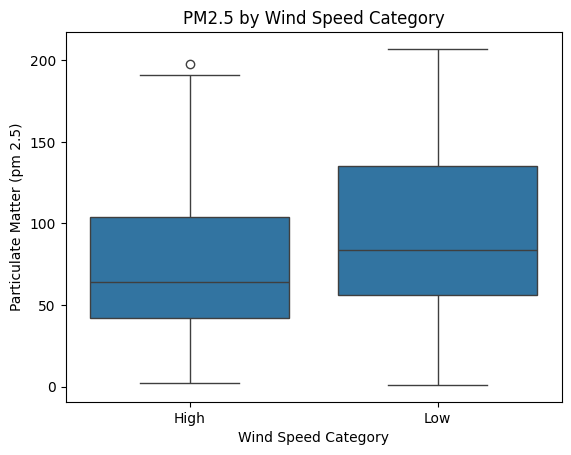

In [21]:
# Exploratory Data Analysis

# Box plot for wind categories
sns.boxplot(x='Wind Speed Category', y='Particulate Matter (pm 2.5)', data=data)
plt.title("PM2.5 by Wind Speed Category")
plt.show()


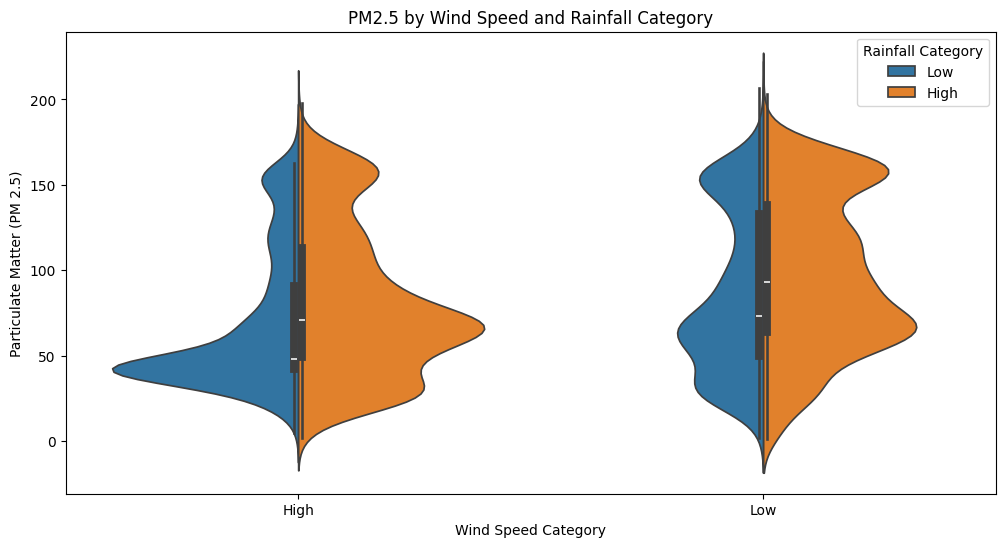

In [22]:
#Violin plot for windspeed and rainfall

plt.figure(figsize=(12, 6))
sns.violinplot(x='Wind Speed Category', y='Particulate Matter (pm 2.5)', hue='Rainfall Category', 
               data=data, split=True)
plt.title("PM2.5 by Wind Speed and Rainfall Category")
plt.xlabel('Wind Speed Category')
plt.ylabel('Particulate Matter (PM 2.5)')
plt.show()

In [23]:
from scipy.stats import ttest_ind, f_oneway, spearmanr

# Subset data for high and low wind speed categories
high_wind = data[data['Wind Speed Category'] == 'High']['Particulate Matter (pm 2.5)']
low_wind = data[data['Wind Speed Category'] == 'Low']['Particulate Matter (pm 2.5)']

# Subset data for high and low rainfall categories
high_rainfall = data[data['Rainfall Category'] == 'High']['Particulate Matter (pm 2.5)']
low_rainfall = data[data['Rainfall Category'] == 'Low']['Particulate Matter (pm 2.5)']

# T-Test: High Wind vs Low Wind PM2.5 levels
t_stat_wind, p_value_wind = ttest_ind(high_wind, low_wind)
print(f"T-statistic for High Wind vs Low Wind: {t_stat_wind}, p-value: {p_value_wind}")

# T-Test: High Rainfall vs Low Rainfall PM2.5 levels
t_stat_rain, p_value_rain = ttest_ind(high_rainfall, low_rainfall)
print(f"T-statistic for High Rainfall vs Low Rainfall: {t_stat_rain}, p-value: {p_value_rain}")

# Spearman correlation (non-linear)
corr_wind, p_wind = spearmanr(data['Wind Speed (w)'], data['Particulate Matter (pm 2.5)'])
corr_rain, p_rain = spearmanr(data['Rainfall or Precipitation (r)'], data['Particulate Matter (pm 2.5)'])
print(f"Wind Speed Correlation: {corr_wind:.3f} (p={p_wind:.4f})")
print(f"Rainfall Correlation: {corr_rain:.3f} (p={p_rain:.4f})")


T-statistic for High Wind vs Low Wind: -17.543522260135664, p-value: 1.065061600232776e-67
T-statistic for High Rainfall vs Low Rainfall: 12.48642399533122, p-value: 1.8264778725765372e-35
Wind Speed Correlation: -0.154 (p=0.0000)
Rainfall Correlation: 0.112 (p=0.0000)
